# Imports

In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import pandas as pd
from queue import PriorityQueue
from math import inf


import osmnx as ox
ox.settings.log_console=True
ox.settings.use_cache=True

c:\Conda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Problemstellung
- Um den kürzesten Pfad von A anch B zu rechnen gibt es eine Vielzahl von Algorithmen. Einer der bekanntesten ist der Dijkstra-Algorithmus.
- Je größer die Graphen werden, desto komplexer wird die Berechnung des kürzesten Pfads.
- Mithilfe von Speed-Up-Techniken kann die Laufzeit des Algorithmus verringert werden.
- Als Beispiel soll die schnellste Route von Stutensee zur Hochschule Karlsruhe berechnet werden. 

## Kartendaten von Open-Street-Map laden

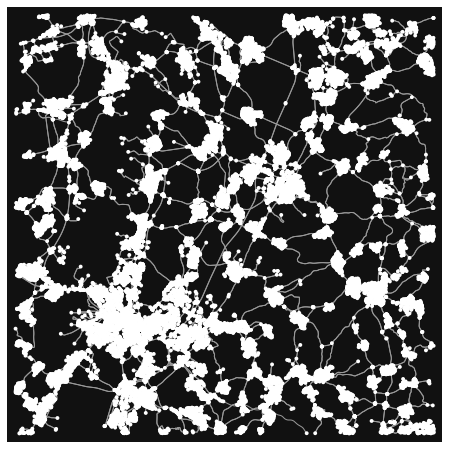

In [2]:
adress = "Weingartener Straße 2, Stutensee, Deutschland"
base_graph = ox.graph_from_address(adress, dist=20000, dist_type='bbox', network_type='drive') # 10000, 20000, 50000
# base_graph = ox.graph_from_place('Baden-Württemberg, Deutschland', network_type='drive', which_result=2)
fig, ax = ox.plot_graph(base_graph)

## Ziel- und Starpunkt von Adresse zu Karte auflösen
- Weg von Stutensee (Wohnort) zur Hochschule.
- Auflösung der Adressen erfolgt über Geocodierung. Diese können zu Koordinaten aufgelöst werden.
- Auf Basis der Koordinaten wird der nächstliegende Knoten in der Karte identifiziert. 

In [3]:
orig_cords = ox.geocode("Weingartener Straße 2, Stutensee, Deutschland")

print(orig_cords[0])
print(orig_cords[1])

orig_node = ox.nearest_nodes(base_graph, orig_cords[1], orig_cords[0])
orig_node

49.0932686
8.51049415


240899210

In [4]:
dest_cords = ox.geocode("Moltkestraße 30, Karlsruhe, Deutschland")

print(dest_cords[0])
print(dest_cords[1])

dest_node = ox.nearest_nodes(base_graph, dest_cords[1], dest_cords[0]) 
dest_node

49.0150447
8.3900574


14795418

## Referenz: Berechnung des kürzesten Weges mit Algorithmen der OS-Bibliothek Network X

In [5]:
route = nx.dijkstra_path(G=base_graph, source=orig_node, target=dest_node, weight='length')

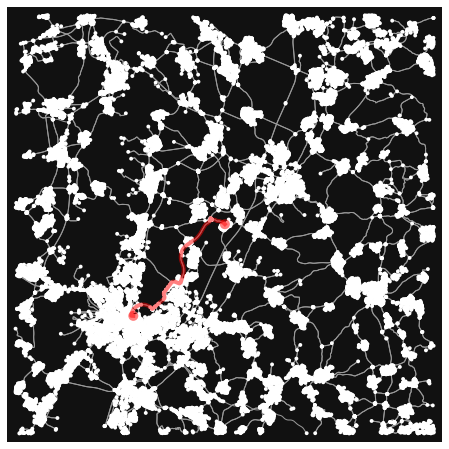

In [6]:
fig, ax = ox.plot_graph_route(base_graph, route, route_color='r')

# Helper Methods

In [7]:
def backtrace(prev, start, end):
    node = end
    path = []
    while node != start:
        path.append(node)
        node = prev[node]
    path.append(node) 
    path.reverse()
    return path

# Basic Dijkstra Algorithm

In [11]:
# Basic Dijkstra 
def dijkstra(graph, start, end):

    #Initialisierung
    # Vorherige Node mit bisher kürzestem Weg zu aktueller Node 
    pred_node = {} 
    # Distanzen initialisieren für alle Nodes inf (unendlich) setzen, außer für unsere Start-Node hier wird 0 gesetzt
    dist = {v: inf for v in list(nx.nodes(graph))} 
    dist[start] = 0
    
    # Bereits besuchte Nodes als Set
    visited = set() 
    
    # prioritize nodes from start -> node with the shortest distance!
    ## elements stored as tuples (distance, node) 
    priority_queue = PriorityQueue()  
    priority_queue.put((dist[start], start))
    
    current_node = start

    # Solange
    while priority_queue.qsize() != 0: # current_node != end:  
        current_node_cost, current_node = priority_queue.get()
        
        # Aktuell besuchte Node zu den besuchten hinzufügen
        visited.add(current_node)
        # Nachfolger der aktuellen Node abrufen und für jeden Nachfolger die Distanz berechnen
        for neighbor in dict(graph.adjacency()).get(current_node):
            path = dist[current_node] + graph.get_edge_data(current_node,neighbor).get('length')

            # Wenn die neue gefundene Distanz über den aktuellen Knoten kürzer ist als die bisher kürzeste Distanz
            if path < dist[neighbor]:
                # Die neue gefundene Distanz als kürzeste Distanz speichern
                dist[neighbor] = path
                # Die aktuelle Node als vorherige Node mit dem kürzesten Weg zur neuen Node setzen 
                pred_node[neighbor] = current_node
                # if we haven't visited the neighbor
                if neighbor not in visited:
                    # insert into priority queue
                    priority_queue.put((dist[neighbor], neighbor))
                # otherwise update the entry in the priority queue
                else:
                    # remove old
                    remove = priority_queue.get((dist[neighbor], neighbor))
                    # insert new
                    priority_queue.put((dist[neighbor], neighbor))
    print(f"Distance: {dist[end]}" )
    print(f"Visited: {len(visited)}")
    return backtrace(pred_node, start, end), dist[end]

In [12]:
di_graph = ox.utils_graph.get_digraph(base_graph, weight="length")

route, dist = dijkstra(di_graph, orig_node, dest_node)

Distance: 16187.009000000005
Visited: 28840


In [13]:
ox.plot_route_folium(base_graph, route)